In [1]:
import matplotlib.pyplot as plt;
from matplotlib.animation import FuncAnimation;
from matplotlib.patches import Ellipse;
import numpy as np;
from scipy.constants import c;
from scipy.interpolate import interp1d;
from scipy.interpolate import UnivariateSpline
from scipy.signal import savgol_filter;
import sys; 
#sys.path.insert(0, "..\\..\\python\\"); # Windows
sys.path.insert(0, "../../python"); # Ubuntu
sys.path.insert(0, "../current_profiles");
from crystal import crystal
import current_profiles as cp;
from ebeam import ebeam;
from laser import laser;
from plotting import makefig;
import phase_retard as pr;
import thz;

In [3]:
# Bunch parameters:
sigz    = 5.2e-6;
sigt    = sigz / c;
dt      = sigt / 10;
N       = 8000;
t       = np.linspace(-N * dt / 2, N * dt / 2, N);
Q_drive = 1.5e-9;
Q_wit   = 0.5e-9;
z_off   = 150e-6;
r0      = 5e-3;
drive   = ebeam({'Q' : Q_drive, 't' : t, 'sigz' : sigz, 'r0' : r0, 'del_z' : 0});
wit     = ebeam({'Q' : Q_wit, 't' : t, 'sigz' : sigz, 'r0' : r0, 'del_z' : z_off});
drive.get_Er(r0); 
wit.get_Er(r0);
Er      = drive.Er + wit.Er;
# Initialize crystals and their parameters
cry = crystal('gap');
d    = 100e-6; # m
nslice = 100;
j     = np.arange(1, nslice, 1);
dz    = d / nslice;
d_arr = (j - 0.5) * dz;
# Initialize probe
y0 = 800e-9; 
dy = 27e-9;
tp = 30e-15;
probe = laser({'y0' : y0, 'dy' : dy, 'tp' : tp});

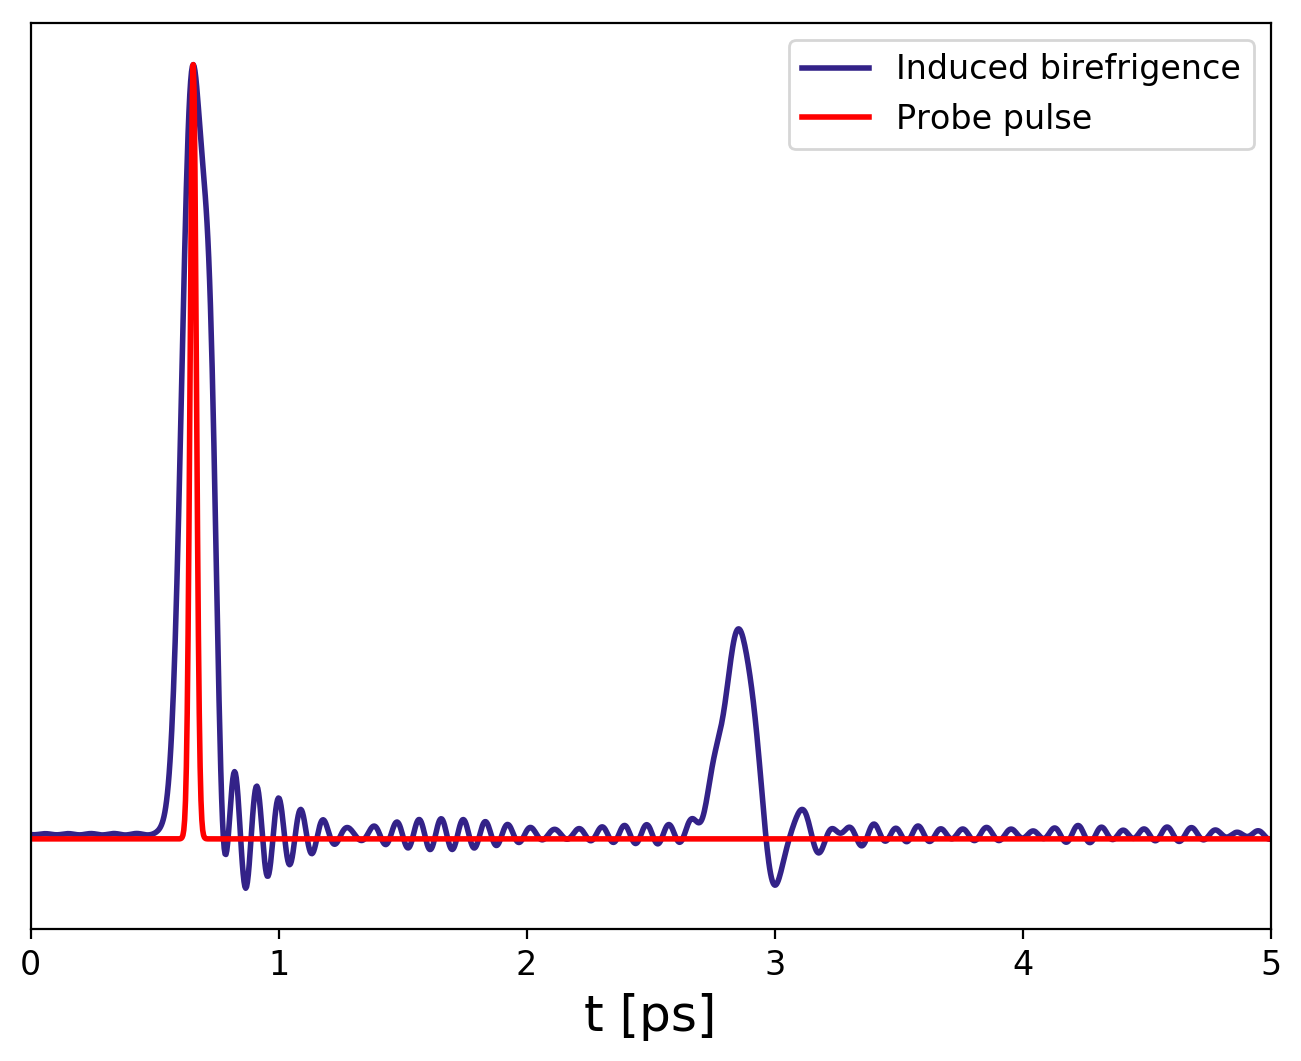

In [6]:
# Plot of induced birefrigence and probe pulse
if True:
    beam = ebeam({'Q' : 1.5e-9, 'sigz' : 13e-6, 'r0' : r0, 'del_z' : 0, 't' : t});
    beam.get_Er(r0)
    FEr, f = thz.raw_field(beam.Er, beam.t);
    Ec, tt = thz.cry_field(beam.t, FEr, f, d, probe, cry, nslice = nslice);
    fig, ax = makefig(x = 8, y = 6, xlab = 't [ps]', fs = 18);
    ax.plot(tt, np.real(Ec[:, 0]) / max(np.real(Ec[:, 0])), label = 'Induced birefrigence', linewidth = 2);
    ind = np.argmax(np.real(Ec[:, 0]));
    env = np.exp(-(tt - tt[ind])**2 / (2 * (probe.sigp * 1e12)**2));
    ax.plot(tt, env, '-r', label = 'Probe pulse', linewidth = 2);
    ax.legend(fontsize = 'large');
    ax.set_xlim([0, 5]);
    ax.set_yticks([]);
    #fig.savefig('thz_prop.svg');

In [11]:
# Longitudinal signal animation
if True:
    del_z_arr = np.linspace(125, 175, 10)*1e-6;
    r0 = 5e-3;
    angle = 15 * np.pi / 180;
    gamma = np.zeros((1000, len(del_z_arr)));
    tau   = np.linspace(0, 3000, 1000) * 1e-15;
    for i in range(len(del_z_arr)):
        if (i+1)%10 == 0:
            print(np.round((i+1) / len(del_z_arr) * 100), "%")
        drive  = ebeam({'Q' : Q_drive, 't' : t, 'sigz' : sigz, 'r0' : r0, 'del_z' : 0});
        wit    = ebeam({'Q' : Q_wit, 't' : t, 'sigz' : sigz, 'r0' : r0, 'del_z' : del_z_arr[i]});
        drive.get_Er(r0)
        wit.get_Er(r0)
        Er     = drive.Er + wit.Er;
        FEr, f = thz.raw_field(Er, drive.t);
        Ec, tt = thz.cry_field(drive.t, FEr, f, d, probe, cry, nslice = nslice);
        gamma[:, i], t_gamma = pr.phase_retard(Ec, tt*1e-12, d_arr, tau, probe, cry, 'spatial', psi = angle);

100.0 %


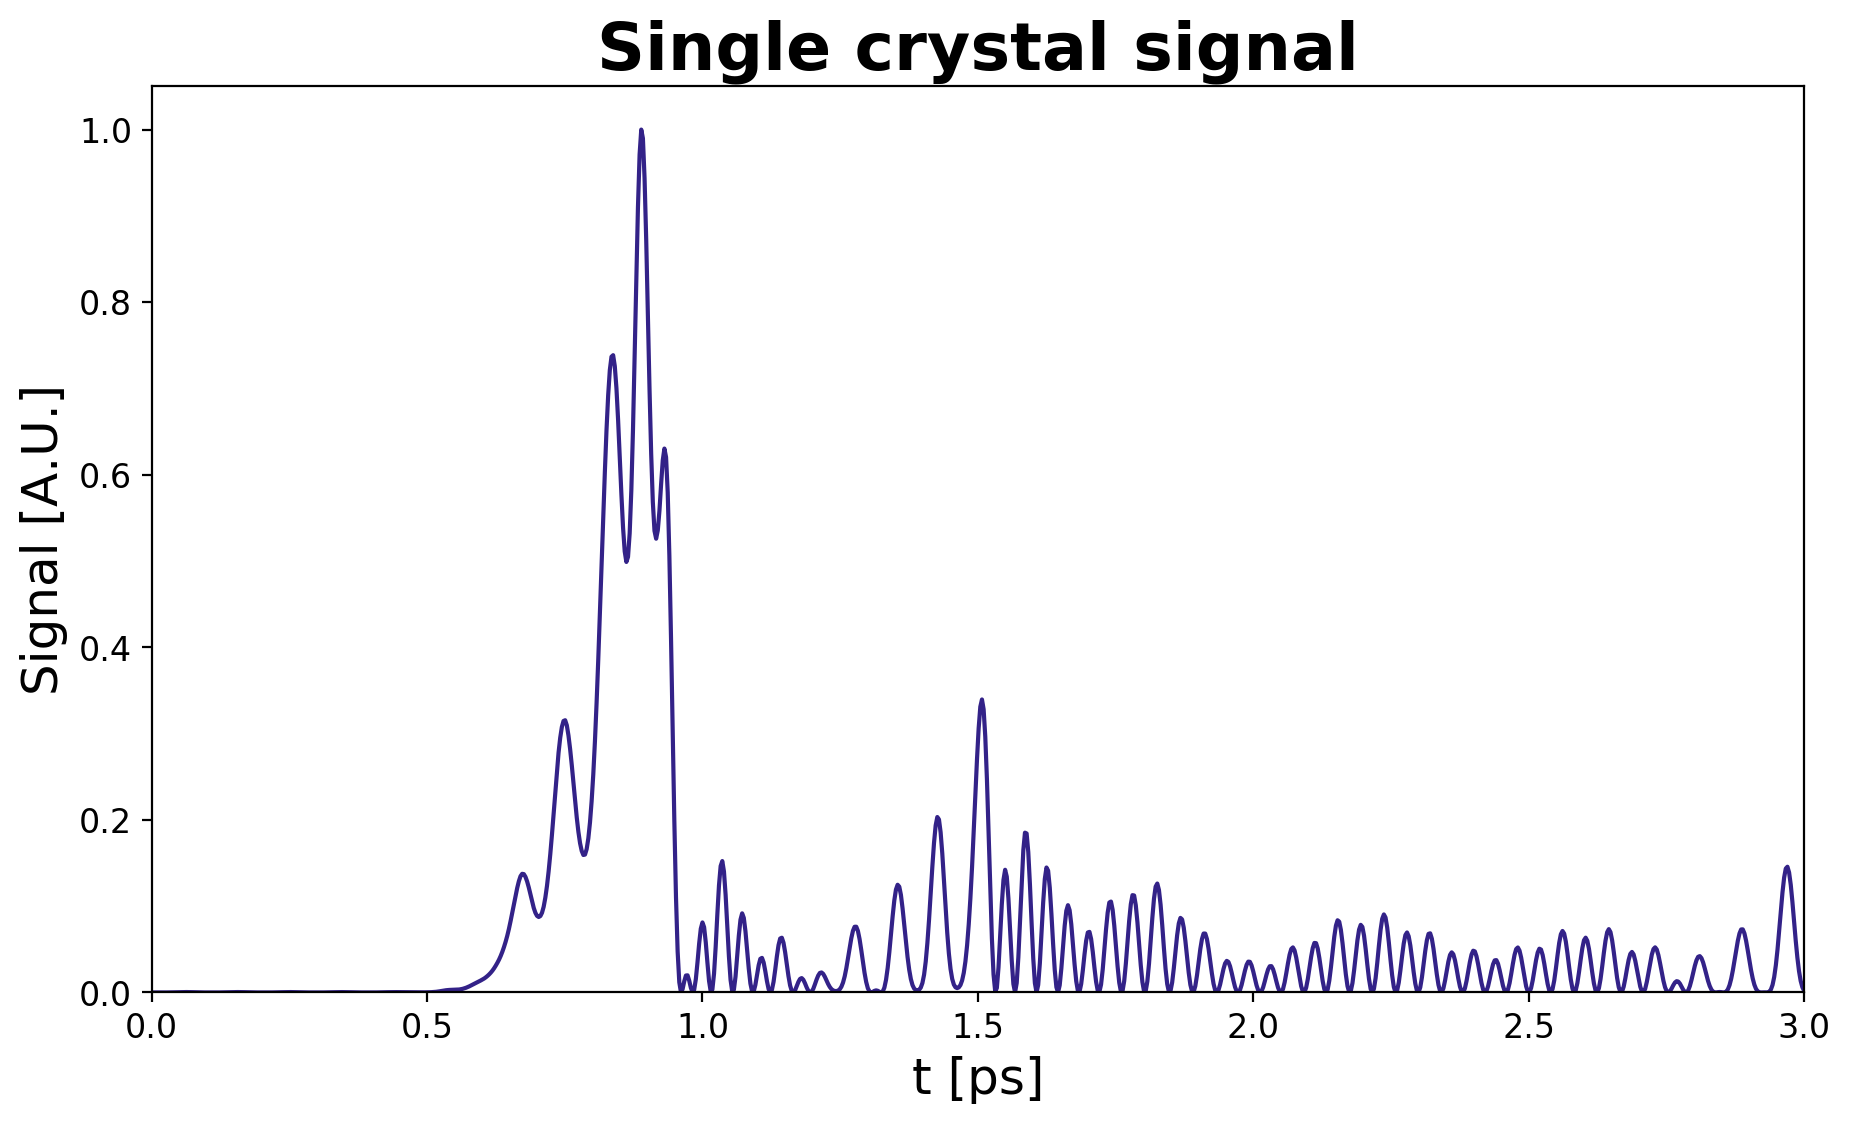

In [12]:
# Longitudinal signal animation
if True:
    fig, ax = makefig(x = 10.667, y = 6, xlab = 't [ps]', ylab = 'Signal [A.U.]', fs = 18, ts = 20);
    xdata, ydata = [], [];
    ln,  = plt.plot([], []);
    sig  = np.sin(gamma / 2)**2;
    def init():
        ax.set_xlim([min(t_gamma*1e12), max(t_gamma*1e12)]);
        ax.set_ylim(0, 1.05);
        return ln,
    def update(frame):
        xdata = t_gamma * 1e12;
        y_data = sig[:, frame] / max(sig[:, frame]);
        ln.set_data(xdata, y_data);
        ax.set_title('Single crystal signal', fontsize= 24, fontweight = 'bold');
        return ln,

    ani = FuncAnimation(fig, update, frames=np.arange(0, len(del_z_arr), 1), init_func = init, interval = 50);
    ani.save('long_signal_ani.mp4');
    plt.show()


In [6]:
# Crystal Geometric response functions
if False:
    gap     = crystal('gap');
    znte    = crystal('znte');
    depths  = np.array([25, 50, 100, 200]) * 1e-6;
    f_gap   = np.linspace(0, 10, 1000) * 1e12;
    f_znte  = np.linspace(0, 5, 1000) * 1e12;
    gap_eo  = gap.georesponse(f_gap, depths, probe);
    znte_eo = znte.georesponse(f_znte, depths, probe);
    
    fig1, ax1 = makefig(x = 8, y = 6, xlab = 'f [THz]', ylab = r'|$G_{EO}$|', fs = 18);
    fig2, ax2 = makefig(x = 8, y = 6, xlab = 'f [THz]', ylab = r'|$G_{EO}$|', fs = 18);
    
    for i in range(len(depths)):
        label = str(np.round(depths[i]*1e6, 0)) + r' $\mu$m';
        ax1.plot(f_gap * 1e-12, np.abs(gap_eo[:, i]), label = label, linewidth = 2);
        ax2.plot(f_znte * 1e-12, np.abs(znte_eo[:, i]), label = label, linewidth = 2);
    ax1.legend(fontsize = 'large');
    ax2.legend(fontsize = 'large');
    fig1.savefig('gap_response.svg');
    fig2.savefig('znte_response.svg');
    plt.show()

In [7]:
# Drive bunch signal difference for 100 micron offset
if False:
    angle   = 15 * np.pi / 180;
    tau     = np.linspace(0, 3000, 1000) * 1e-15;
    r0      = 1e-3;
    x_off_a = 100e-6;
    x_off_b = -100e-6;
    drive_a = ebeam({'Q' : Q_drive, 't' : t, 'sigz' : sigz, 'r0' : r0 + x_off_a, 'del_z' : 0});
    drive_b = ebeam({'Q' : Q_drive, 't' : t, 'sigz' : sigz, 'r0' : r0 + x_off_b, 'del_z' : 0});
    wit     = ebeam({'Q' : Q_wit, 't' : t, 'sigz' : sigz, 'r0' : r0, 'del_z' : z_off});
    Er_a    = drive_a.Er + wit.Er;
    Er_b    = drive_b.Er + wit.Er;
    FEr_a, f_a = thz.raw_field(Er_a, drive_a.t);
    FEr_b, f_b = thz.raw_field(Er_b, drive_b.t);
    Ec_a, tt_a = thz.cry_field(drive_a.t, FEr_a, f_a, d, probe, cry, nslice = nslice);
    Ec_b, tt_b = thz.cry_field(drive_b.t, FEr_b, f_b, d, probe, cry, nslice = nslice);
    gamma_a, t_gamma_a = pr.phase_retard(Ec_a, tt_a*1e-12, d_arr, tau, probe, cry, 'spatial', psi = angle);
    gamma_b, t_gamma_b = pr.phase_retard(Ec_b, tt_b*1e-12, d_arr, tau, probe, cry, 'spatial', psi = angle);
    
    sig_a = np.sin(gamma_a / 2)**2;
    sig_b = np.sin(gamma_b / 2)**2;
    
    sig_diff = sig_a - sig_b;
    
    fig, ax = makefig(x = 10.667, y = 6, xlab = 't [fs]', ylab = 'Signal [A.U.]', title = 'Drive beam EO signal difference', \
                      fs = 18, ts = 24);
    ax.plot(t_gamma_a * 1e15, sig_diff / max(sig_diff))
    ax.set_xlim([300, 900])
    fig.savefig('drive_sig_diff.svg')
    plt.show();

In [8]:
# Witness bunch signal difference for 100 micron offset
if False:
    angle   = 15 * np.pi / 180;
    tau     = np.linspace(0, 3000, 1000) * 1e-15;
    r0      = 1e-3;
    x_off_a = 100e-6;
    x_off_b = -100e-6;
    drive   = ebeam({'Q' : Q_drive, 't' : t, 'sigz' : sigz, 'r0' : r0, 'del_z' : 0});
    wit_a   = ebeam({'Q' : Q_wit, 't' : t, 'sigz' : sigz, 'r0' : r0 + x_off_a, 'del_z' : z_off});
    wit_b   = ebeam({'Q' : Q_wit, 't' : t, 'sigz' : sigz, 'r0' : r0 + x_off_b, 'del_z' : z_off});
    Er_a    = drive.Er + wit_a.Er;
    Er_b    = drive.Er + wit_b.Er;
    FEr_a, f_a = thz.raw_field(Er_a, drive.t);
    FEr_b, f_b = thz.raw_field(Er_b, drive.t);
    Ec_a, tt_a = thz.cry_field(drive.t, FEr_a, f_a, d, probe, cry, nslice = nslice);
    Ec_b, tt_b = thz.cry_field(drive.t, FEr_b, f_b, d, probe, cry, nslice = nslice);
    gamma_a, t_gamma_a = pr.phase_retard(Ec_a, tt_a*1e-12, d_arr, tau, probe, cry, 'spatial', psi = angle);
    gamma_b, t_gamma_b = pr.phase_retard(Ec_b, tt_b*1e-12, d_arr, tau, probe, cry, 'spatial', psi = angle);
    
    sig_a = np.sin(gamma_a / 2)**2;
    sig_b = np.sin(gamma_b / 2)**2;
    
    sig_diff = sig_a - sig_b;
    
    fig, ax = makefig(x = 10.667, y = 6, xlab = 't [fs]', ylab = 'Signal [A.U.]', \
                      title = 'Witness beam EO signal difference', \
                      fs = 18, ts = 24);
    ax.plot(t_gamma_a * 1e15, sig_diff / max(abs(sig_diff)))
    ax.set_xlim([900, 1300])
    fig.savefig('wit_sig_diff.svg')
    plt.show();

In [9]:
# Drive bunch signal difference animation
if True:
    x_offset = np.linspace(-100, 100, 100) * 1e-6;
    angle    = 15 * np.pi / 180;
    r0       = 1e-3;
    wit      = ebeam({'Q' : Q_wit, 't' : t, 'sigz' : sigz, 'r0' : r0, 'del_z' : z_off});
    gamma    = np.zeros((10000, len(x_offset)));
    tau      = np.linspace(0, 3000, 1000) * 1e-15;
    for i in range(len(x_offset)):
        if (i+1)%10 == 0:
            print(np.round((i+1) / len(x_offset) * 100), "%")
        drive  = ebeam({'Q' : Q_drive, 't' : t, 'sigz' : sigz, 'r0' : r0 + x_offset[i], 'del_z' : 0});
        Er     = drive.Er + wit.Er;
        FEr, f = thz.raw_field(Er, drive.t);
        Ec, tt = thz.cry_field(drive.t, FEr, f, d, probe, cry, nslice = nslice);
        gamma[:, i], t_gamma = pr.phase_retard(Ec, tt*1e-12, d_arr, tau, probe, cry, 'spatial', psi = angle);

10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
100.0 %


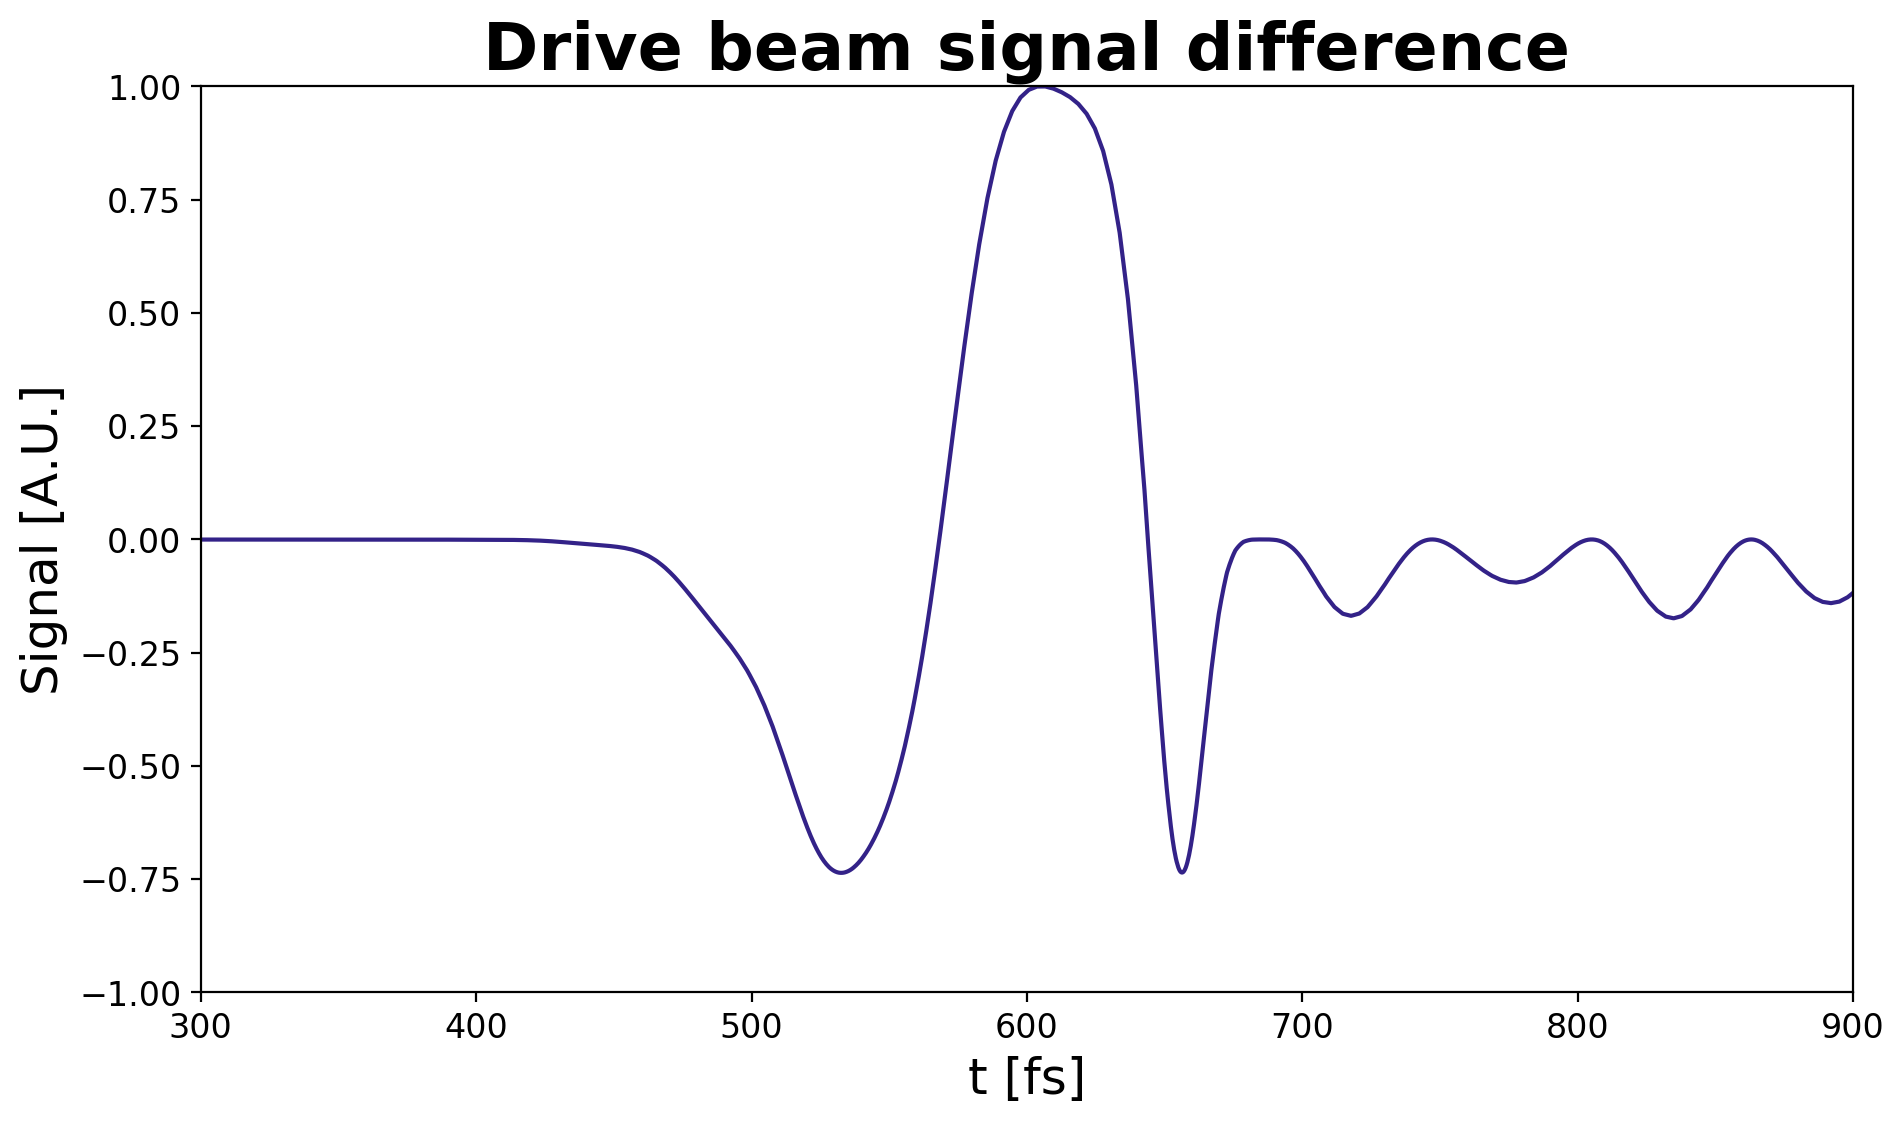

In [10]:
# Drive bunch signal difference animation
if True:
    fig, ax = makefig(x = 10.667, y = 6, xlab = 't [fs]', ylab = 'Signal [A.U.]', fs = 18, ts = 20);
    xdata, ydata = [], [];
    ln,  = plt.plot([], []);
    sig1 = np.sin(gamma / 2)**2;
    sig1 = sig1 / np.amax(sig1);
    sig2 = np.flip(sig1, axis = 1);
    sig = sig1 - sig2;
    sig = sig / np.amax(sig);
    def init():
        ax.set_xlim([300, 900]);
        ax.set_ylim(-1.0, 1.0);
        return ln,
    def update(frame):
        xdata = t_gamma * 1e15;
        y_data = sig[:, frame] #/ drive_norm;
        ln.set_data(xdata, y_data);
        #mytext = str(np.round(x_offset[frame] * 1e3)) + r'$\mu$m';
        ax.set_title('Drive beam signal difference',\
                     fontsize= 24, fontweight = 'bold');
        return ln,

    ani = FuncAnimation(fig, update, frames=np.arange(0, len(x_offset), 1), init_func = init, interval = 50);
    ani.save('drive_signal_ani.mp4');
    plt.show()

In [11]:
# Witness bunch signal difference animation
if True:
    x_offset = np.linspace(-100, 100, 100) * 1e-6;
    angle    = 15 * np.pi / 180;
    r0       = 1e-3;
    drive    = ebeam({'Q' : Q_drive, 't' : t, 'sigz' : sigz, 'r0' : r0, 'del_z' : 0});
    gamma    = np.zeros((10000, len(x_offset)));
    tau      = np.linspace(0, 3000, 1000) * 1e-15;
    for i in range(len(x_offset)):
        if (i+1)%10 == 0:
            print(np.round((i+1) / len(x_offset) * 100), "%")
        wit    = ebeam({'Q' : Q_wit, 't' : t, 'sigz' : sigz, 'r0' : r0 + x_offset[i], 'del_z' : z_off});
        Er     = drive.Er + wit.Er;
        FEr, f = thz.raw_field(Er, drive.t);
        Ec, tt = thz.cry_field(drive.t, FEr, f, d, probe, cry, nslice = nslice);
        gamma[:, i], t_gamma = pr.phase_retard(Ec, tt*1e-12, d_arr, tau, probe, cry, 'spatial', psi = angle);

10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
100.0 %


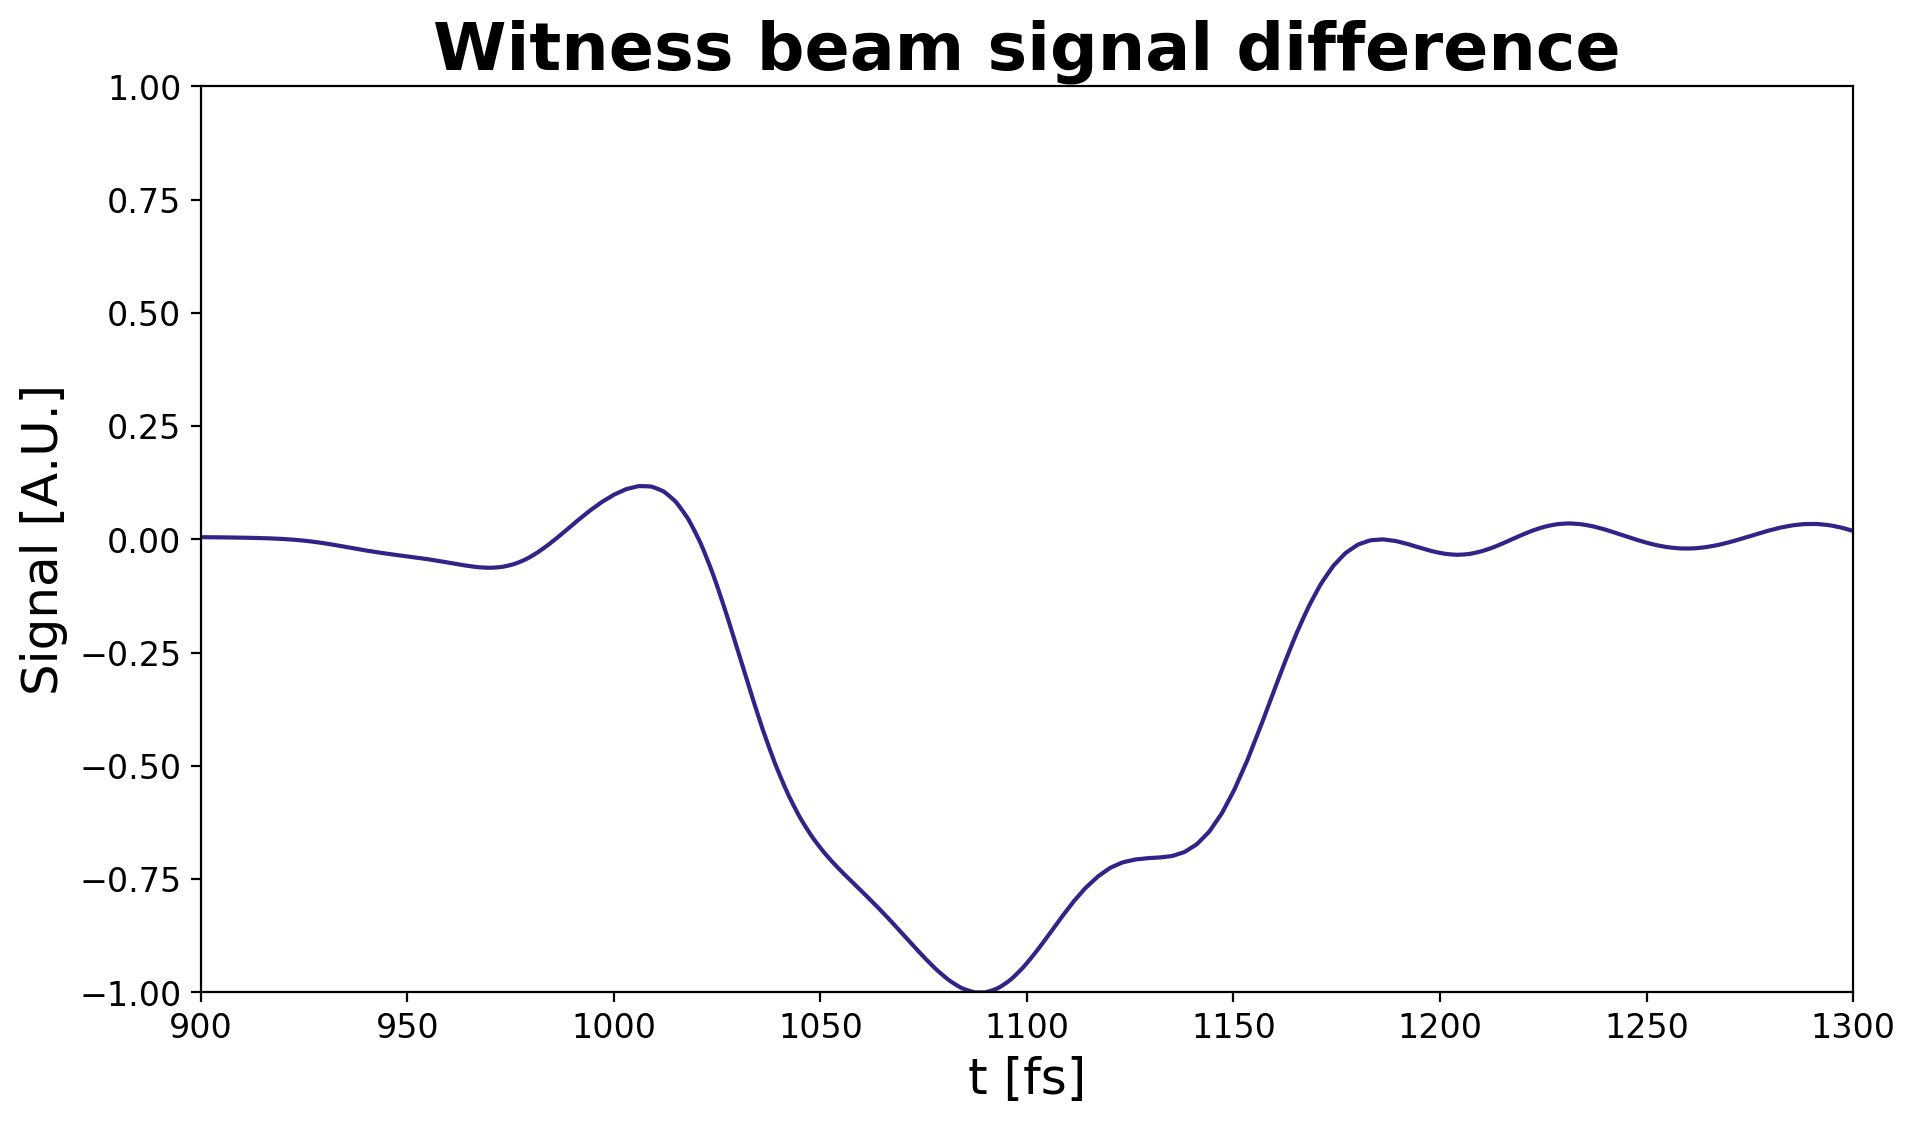

In [12]:
# Witness bunch signal difference animation
if True:
    fig, ax = makefig(x = 10.667, y = 6, xlab = 't [fs]', ylab = 'Signal [A.U.]', fs = 18, ts = 20);
    xdata, ydata = [], [];
    ln,  = plt.plot([], []);
    sig1 = np.sin(gamma / 2)**2;
    sig1 = sig1 / np.amax(sig1);
    sig2 = np.flip(sig1, axis = 1);
    sig = sig1 - sig2;
    sig = sig / np.amax(sig);
    def init():
        ax.set_xlim([900, 1300]);
        ax.set_ylim(-1.0, 1.0);
        return ln,
    def update(frame):
        xdata = t_gamma * 1e15;
        y_data = sig[:, frame] #/ drive_norm;
        ln.set_data(xdata, y_data);
        ax.set_title('Witness beam signal difference',\
                     fontsize= 24, fontweight = 'bold');
        return ln,

    ani = FuncAnimation(fig, update, frames=np.arange(0, len(x_offset), 1), init_func = init, interval = 50);
    ani.save('wit_signal_ani.mp4');
    plt.show()

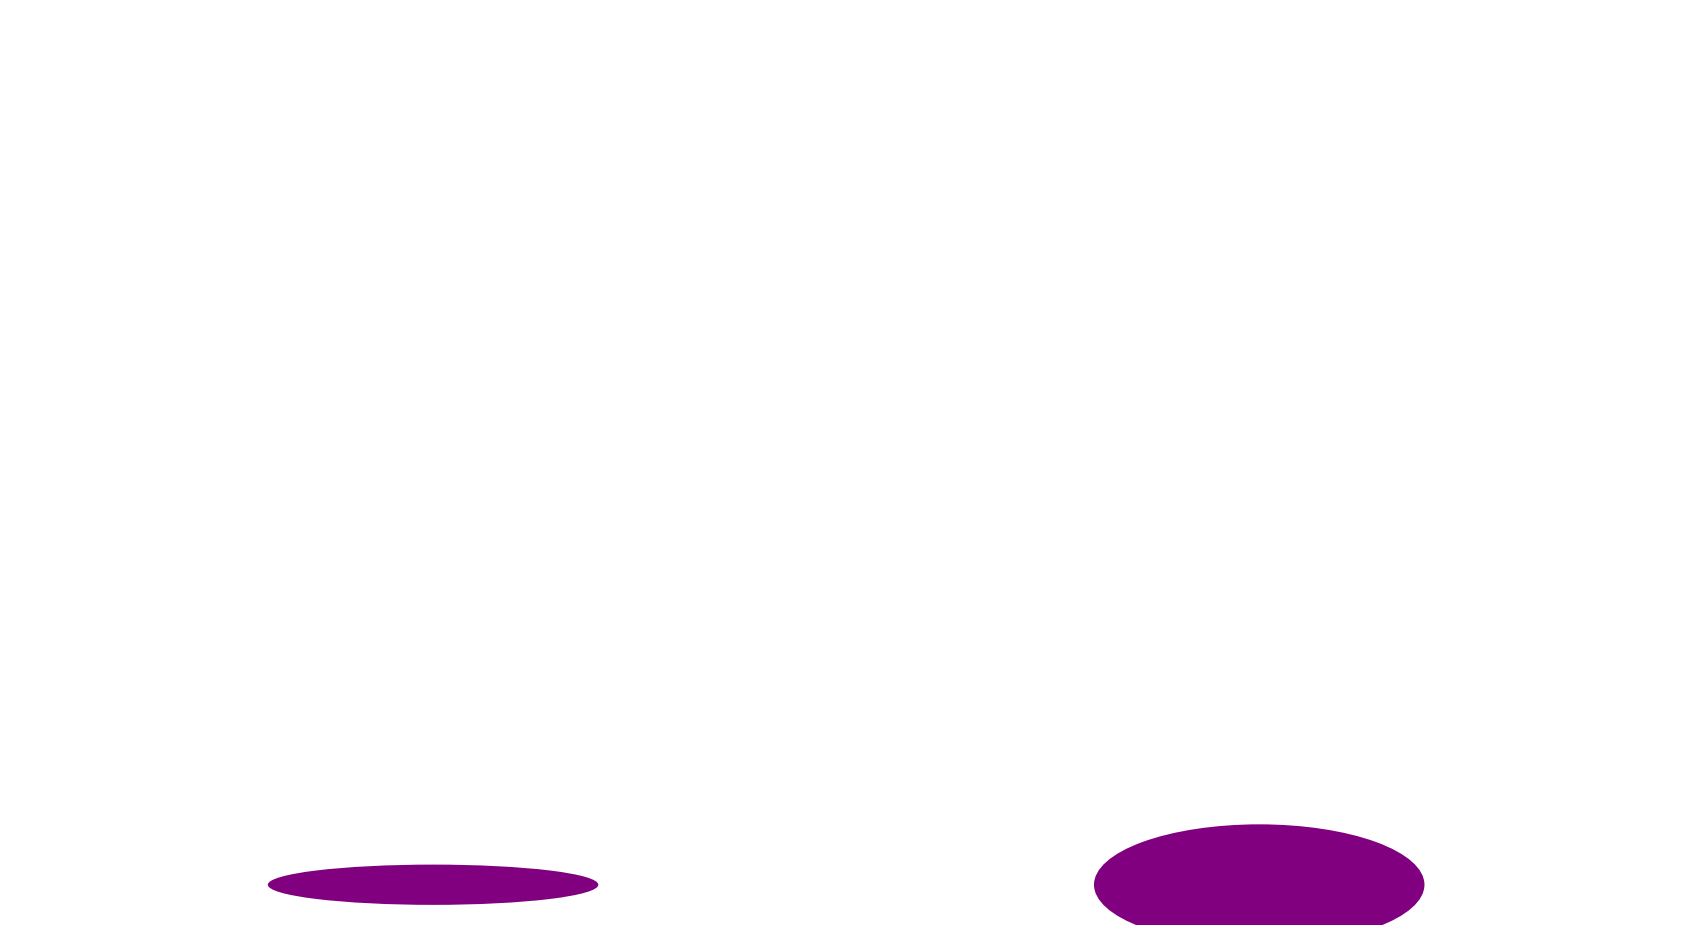

In [13]:
# Transverse bunches animation

if True:
    y_arr = np.linspace(-100, 100, 100);
    y_arr = np.flip(y_arr, axis = 0);
    fig, ax = makefig(x = 10.667, y = 6)
    e1 = Ellipse(xy=(50, 100), width=8, height=30, fc = 'purple')
    e2 = Ellipse(xy=(30, 100), width=8, height=10, fc = 'purple')
    ax.add_patch(e1)
    ax.add_patch(e2)
    ax.set_ylim([-110, 115])
    ax.set_xlim([20, 60])
    ax.set_xticks([]);
    ax.set_yticks([]);
    ax.axis('off')
    def init():
        e1.set_visible(False)
        e2.set_visible(False)
        return [e1, e2]

    def animate(i):
        if i == 1:
            e1.set_visible(True)
            e2.set_visible(True)
        e1.set_center((50, y_arr[i]))
        e2.set_center((30,y_arr[i]));
        return [e1, e2]
    anim = FuncAnimation(fig, animate, frames = np.arange(0, len(y_arr), 1), init_func=init, interval=50, blit=True)
    anim.save('transverse_ani.mp4')
    plt.show()

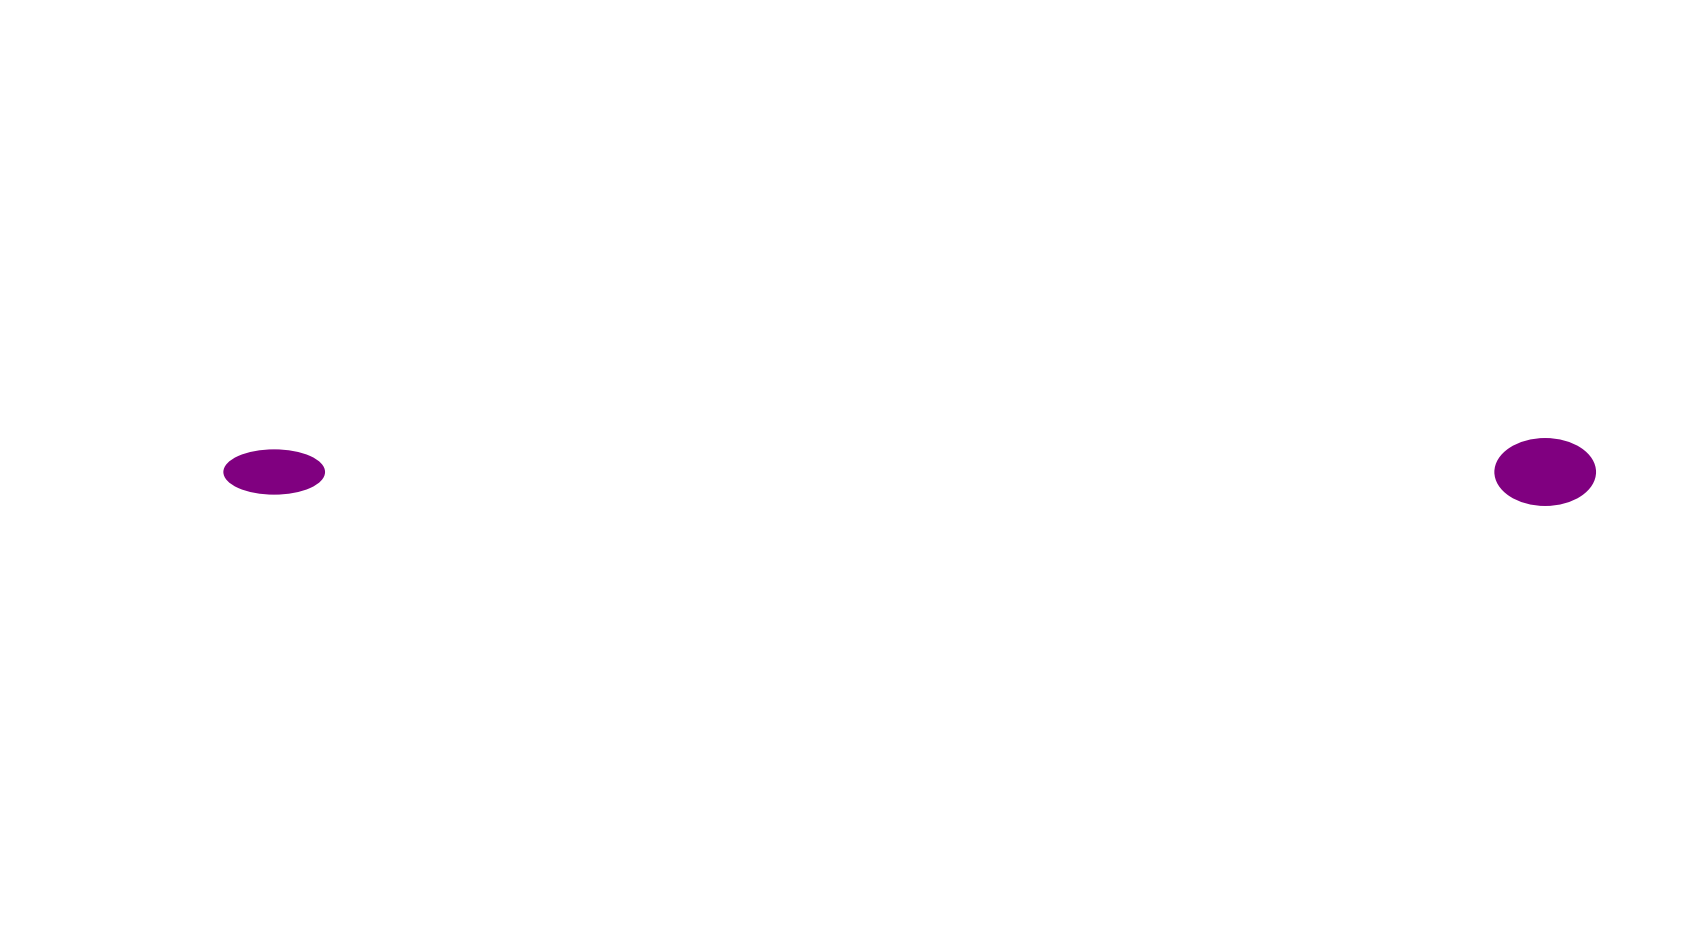

In [14]:
# Longitudinal bunches animation
if True:
    x_arr = np.linspace(125, 175, 100) - 75 ;
    fig, ax = makefig(x = 10.667, y = 6)
    e1 = Ellipse(xy=(0, 100), width=8, height=1.5, fc = 'purple')
    e2 = Ellipse(xy=(-125, 100), width=8, height=1, fc = 'purple')
    ax.add_patch(e1)
    ax.add_patch(e2)
    ax.set_ylim([90, 110])
    ax.set_xlim([-120, 10])
    ax.set_xticks([]);
    ax.set_yticks([]);
    ax.axis('off')
    def init():
        e1.set_visible(False)
        e2.set_visible(False)
        return [e1, e2]

    def animate(i):
        if i == 1:
            e1.set_visible(True)
            e2.set_visible(True)
        new_x = -x_arr[i]
        e2.set_center((new_x,100));
        return [e1, e2]
    anim = FuncAnimation(fig, animate, frames = np.arange(0, len(y_arr), 1), init_func=init, interval=50, blit=True)
    anim.save('Longitudinal_Animation.mp4')
    plt.show()

In [15]:
# Longitudinal resolution of the detector
if False:
    def centroid(sig, t, mid, dt):
        max_ind       = np.argmax(sig);
        mid_ind       = np.argmin(abs(t*1e15 - mid));
        wit_ind       = np.argmax(sig[mid_ind:-1]) + mid_ind;
        
        drive_min_ind = np.argmin(sig[0:max_ind] - 0.1 * max(sig))
        drive_max_ind = np.argmin(sig[max_ind:-1] - 0.1*max(sig));
        drive_curve   = sig[max_ind-dt:max_ind+dt];
        t_drive       = t[max_ind-dt:max_ind+dt];
        wit_curve     = sig[wit_ind-dt:wit_ind+dt];
        t_wit         = t[wit_ind-dt:wit_ind+dt];
        
        drive1        = np.argmin(abs(drive_curve[0:np.argmax(drive_curve)] - max(drive_curve) / 2));
        drive2        = np.argmin(abs(drive_curve[np.argmax(drive_curve):-1] - max(drive_curve) / 2));
        drive2        = drive2 + np.argmax(drive_curve);
        drive_width   = abs(t_drive[drive1] - t_drive[drive2])
        drive_centroid = t_drive[drive1] + drive_width / 2;
        
        wit1         = np.argmin(abs(wit_curve[0:np.argmax(wit_curve)] - max(wit_curve) / 2));
        wit2         = np.argmin(abs(wit_curve[np.argmax(wit_curve):-1] - max(wit_curve) / 2));
        wit2         = wit2 + np.argmax(wit_curve);
        wit_width    = abs(t_wit[wit1] - t_wit[wit2]);
        wit_centroid = t_wit[wit1] + wit_width / 2;
        
        return abs(drive_centroid - wit_centroid) * c * 1e6;
    tau = np.linspace(-500, 2500, 1000) * 1e-15
    angle = 15 * np.pi / 180;
    r0 = 5e-3;
    fig1, ax1 = makefig(x = 10.667, y = 6, xlab = 't [fs]', ylab = 'I [kA]', title = 'Input current profile',\
                        fs = 18, ts = 24);
    fig2, ax2 = makefig(x = 10.667, y = 6, xlab = 't [fs]', ylab = 'Signal [A.U.]', title = 'Single crystal signal', \
                       fs = 18, ts = 24);
    for i in range(10):
        if i != 1 and i!=3 and i!=6 and i!=8:
            I, ti, z, dz, dt = cp.get_current(i);
            maxI_ind = np.argmax(I)
            mid_ind  = np.argmin(abs(ti*1e15 - 200));
            witI_ind = np.argmax(I[mid_ind:-1]) + mid_ind
            #print("Input peak to peak", centroid(I, ti, 200, 50), "microns")
            ax1.plot(ti * 1e15, I)
            E, ze, te = cp.get_E(I, ti, z, r0);
            E = np.flip(E, axis = 0);
            te = te - te[np.argmax(E)];
            f_E_int = interp1d(te, E)
            te_int  = np.linspace(te[0], -te[0], 1000);
            E_int   = f_E_int(te_int);
            FEr, f = thz.raw_field(E_int, te_int);
            Ec, tt = thz.cry_field(te_int, FEr, f, d, probe, cry, nslice = nslice);
            gamma, t_gamma = pr.phase_retard(Ec, tt*1e-12, d_arr, tau, probe, cry, 'spatial', psi = angle);
            sig = np.sin(gamma / 2)**2
            ax2.plot(t_gamma * 1e15, sig / max(sig));
            max_sig_ind = np.argmax(sig);
            mid_ind     = np.argmin(abs(t_gamma*1e15 - 400))
            wit_sig_ind = np.argmax(sig[mid_ind:-1]) + mid_ind
            #print("Signal peak to peak", centroid(sig, t_gamma, 200, 300), "microns")
            #print("--------------------------------------------------------------------")
    ax2.set_xlim([-200, max(te_int*1e15)])
    fig1.savefig("input_current.svg")
    fig2.savefig("current_signal.svg")

In [16]:
# Longitudinal resolution of the detector (with laser heater, and FWHM find distance)
if False:
    def centroid(sig, t, mid, dt):
        max_ind       = np.argmax(sig);
        mid_ind       = np.argmin(abs(t*1e15 - mid));
        wit_ind       = np.argmax(sig[mid_ind:-1]) + mid_ind;
        
        drive_min_ind = np.argmin(sig[0:max_ind] - 0.1 * max(sig))
        drive_max_ind = np.argmin(sig[max_ind:-1] - 0.1*max(sig));
        drive_curve   = sig[max_ind-dt:max_ind+dt];
        t_drive       = t[max_ind-dt:max_ind+dt];
        wit_curve     = sig[wit_ind-dt:wit_ind+dt];
        t_wit         = t[wit_ind-dt:wit_ind+dt];
        
        drive1        = np.argmin(abs(drive_curve[0:np.argmax(drive_curve)] - max(drive_curve) / 2));
        drive2        = np.argmin(abs(drive_curve[np.argmax(drive_curve):-1] - max(drive_curve) / 2));
        drive2        = drive2 + np.argmax(drive_curve);
        drive_width   = abs(t_drive[drive1] - t_drive[drive2])
        drive_centroid = t_drive[drive1] + drive_width / 2;
        
        wit1         = np.argmin(abs(wit_curve[0:np.argmax(wit_curve)] - max(wit_curve) / 2));
        wit2         = np.argmin(abs(wit_curve[np.argmax(wit_curve):-1] - max(wit_curve) / 2));
        wit2         = wit2 + np.argmax(wit_curve);
        wit_width    = abs(t_wit[wit1] - t_wit[wit2]);
        wit_centroid = t_wit[wit1] + wit_width / 2;
        
        return abs(drive_centroid - wit_centroid) * c * 1e6;
        
    tau = np.linspace(-500, 2500, 1000) * 1e-15
    angle = 15 * np.pi / 180;
    r0 = 5e-3;
    fig1, ax1 = makefig(x = 10.667, y = 6, xlab = 't [fs]', ylab = 'I [kA]', title = 'Input current profile',\
                       fs = 18, ts = 24);
    fig2, ax2 = makefig(x = 10.667, y = 6, xlab = 't [fs]', ylab = 'Signal [A.U.]', title = 'Single crystal signal', \
                       fs = 18, ts = 24);
    for i in range(10):
        if i != 1 and i!=3 and i!=6 and i!=8:
            I, ti, z, dz, dt = cp.get_current(i);
            I = savgol_filter(I, window_length = 51, polyorder = 3);
            I[I < 0] = 0;
            maxI_ind = np.argmax(I);
            mid_ind  = np.argmin(abs(ti*1e15 - 200));
            witI_ind = np.argmax(I[mid_ind:-1]) + mid_ind;
            centroid(I, ti, 200, 50)
            #print("Input peak to peak", centroid(I, ti, 200, 50), "microns");
            ax1.plot(ti * 1e15, I);
            E, ze, te = cp.get_E(I, ti, z, r0);
            E[E < 0] = 0;
            E = np.flip(E, axis = 0);
            te = te - te[np.argmax(E)];
            f_E_int = interp1d(te, E);
            te_int  = np.linspace(te[0], -te[0], 1000);
            E_int   = f_E_int(te_int);
            FEr, f = thz.raw_field(E_int, te_int);
            Ec, tt = thz.cry_field(te_int, FEr, f, d, probe, cry, nslice = nslice);
            gamma, t_gamma = pr.phase_retard(Ec, tt*1e-12, d_arr, tau, probe, cry, 'spatial', psi = angle);
            sig = np.sin(gamma / 2)**2;
            ax2.plot(t_gamma * 1e15, sig / max(sig));
            max_sig_ind = np.argmax(sig);
            mid_ind     = np.argmin(abs(t_gamma*1e15 - 400));
            wit_sig_ind = np.argmax(sig[mid_ind:-1]) + mid_ind;
            #print("Signal peak to peak", centroid(sig, t_gamma, 200, 300), "microns");
            #print("--------------------------------------------------------------------")
    ax2.set_xlim([-200, max(te_int*1e15)]);
    fig1.savefig("smooth_input_current.svg");
    fig2.savefig("smooth_current_signal.svg");

In [17]:
# Individual crystal signals and signal difference (drive)
if False:
    x_offset = np.array([-100, -50, 0, 50, 100])*1e-6;
    angle    = 15 * np.pi / 180;
    r0       = 1e-3;
    wit      = ebeam({'Q' : Q_wit, 't' : t, 'sigz' : sigz, 'r0' : r0, 'del_z' : z_off});
    gamma    = np.zeros((10000, len(x_offset)));
    tau      = np.linspace(0, 3000, 1000) * 1e-15;
    for i in range(len(x_offset)):
        if (i+1)%10 == 0:
            print(np.round((i+1) / len(x_offset) * 100), "%")
        drive  = ebeam({'Q' : Q_drive, 't' : t, 'sigz' : sigz, 'r0' : r0 + x_offset[i], 'del_z' : 0});
        Er     = drive.Er + wit.Er;
        FEr, f = thz.raw_field(Er, drive.t);
        Ec, tt = thz.cry_field(drive.t, FEr, f, d, probe, cry, nslice = nslice);
        gamma[:, i], t_gamma = pr.phase_retard(Ec, tt*1e-12, d_arr, tau, probe, cry, 'spatial', psi = angle);

In [18]:
# Individual crystal signals and signal difference (drive)
if False:
    fig1, ax1 = makefig(x = 10.667, y = 6, xlab = 't [fs]', ylab = 'Signal [A.U.]', title = 'Crystal A signal', \
                       fs = 18, ts = 24);
    fig2, ax2 = makefig(x = 10.667, y = 6, xlab = 't [fs]', ylab = 'Signal [A.U.]', title = 'Crystal B signal', \
                       fs = 18, ts = 24);
    fig3, ax3 = makefig(x = 10.667, y = 6, xlab = 't [fs]', ylab = 'Signal [A.U.]', \
                        title = 'Dual crystal signal difference', \
                        fs = 18, ts = 24);
    siga = np.sin(gamma / 2)**2;
    sigb = np.flip(siga, axis = 1);
    sigc = siga - sigb;
    siga = siga/np.amax(siga);
    sigb = sigb/np.amax(sigb);
    sigc = sigc/np.amax(sigc);
    for i in range(len(x_offset)):
        lab = r'$\Delta$x = ' + str(np.round(x_offset[i]*1e6)) + r' $\mu$m';
        ax1.plot(t_gamma * 1e15, siga[:, i], label = lab, linewidth = 2);
        ax2.plot(t_gamma * 1e15, sigb[:, i], label = lab,  linewidth = 2);
        ax3.plot(t_gamma * 1e15, sigc[:, i], label = lab, linewidth = 2);
    ax1.legend(fontsize = 'large');
    ax2.legend(fontsize = 'large');
    ax3.legend(fontsize = 'large');
    
    ax1.set_xlim([300, 900]);
    ax2.set_xlim([300, 900]);
    ax3.set_xlim([300, 900]);
    
    fig1.savefig('crystal_a_drive.svg');
    fig2.savefig('crystal_b_drive.svg');
    fig3.savefig('crystal_diff_drive.svg');
    plt.show();

In [19]:
# Individual crystal signals and signal difference (drive)
if False:
    x_offset = np.array([-100, -50, 0, 50, 100])*1e-6;
    angle    = 15 * np.pi / 180;
    r0       = 1e-3;
    drive  = ebeam({'Q' : Q_drive, 't' : t, 'sigz' : sigz, 'r0' : r0, 'del_z' : 0});
    
    gamma    = np.zeros((10000, len(x_offset)));
    tau      = np.linspace(0, 3000, 1000) * 1e-15;
    for i in range(len(x_offset)):
        if (i+1)%10 == 0:
            print(np.round((i+1) / len(x_offset) * 100), "%")
        wit      = ebeam({'Q' : Q_wit, 't' : t, 'sigz' : sigz, 'r0' : r0 + x_offset[i], 'del_z' : z_off});
        Er     = drive.Er + wit.Er; 
        FEr, f = thz.raw_field(Er, drive.t);
        Ec, tt = thz.cry_field(drive.t, FEr, f, d, probe, cry, nslice = nslice);
        gamma[:, i], t_gamma = pr.phase_retard(Ec, tt*1e-12, d_arr, tau, probe, cry, 'spatial', psi = angle);

In [20]:
# Individual crystal signals and signal difference (witness)
if False:
    fig1, ax1 = makefig(x = 10.667, y = 6, xlab = 't [fs]', ylab = 'Signal [A.U.]', title = 'Crystal A signal', \
                       fs = 18, ts = 24);
    fig2, ax2 = makefig(x = 10.667, y = 6, xlab = 't [fs]', ylab = 'Signal [A.U.]', title = 'Crystal B signal', \
                       fs = 18, ts = 24);
    fig3, ax3 = makefig(x = 10.667, y = 6, xlab = 't [fs]', ylab = 'Signal [A.U.]', \
                        title = 'Dual crystal signal difference', \
                        fs = 18, ts = 24);
    siga = np.sin(gamma / 2)**2;
    sigb = np.flip(siga, axis = 1);
    sigc = siga - sigb;
    ind1 = np.argmin(abs(t_gamma - 900e-15));
    ind2 = np.argmin(abs(t_gamma - 1300e-15));
    siga = siga/np.amax(siga[ind1:ind2]);
    sigb = sigb/np.amax(sigb[ind1:ind2]);
    sigc = sigc/np.amax(sigc[ind1:ind2]);
    for i in range(len(x_offset)):
        lab = r'$\Delta$x = ' + str(np.round(x_offset[i]*1e6)) + r' $\mu$m';
        ax1.plot(t_gamma * 1e15, siga[:, i], label = lab, linewidth = 2);
        ax2.plot(t_gamma * 1e15, sigb[:, i], label = lab,  linewidth = 2);
        ax3.plot(t_gamma * 1e15, sigc[:, i], label = lab, linewidth = 2);
    ax1.legend(fontsize = 'large');
    ax2.legend(fontsize = 'large');
    ax3.legend(fontsize = 'large');
    
    ax1.set_xlim([900, 1300]);
    ax2.set_xlim([900, 1300]);
    ax3.set_xlim([900, 1300]);
    
    fig1.savefig('crystal_a_wit.svg');
    fig2.savefig('crystal_b_wit.svg');
    fig3.savefig('crystal_diff_wit.svg');
    plt.show();